In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    epochs=100
    early_stopping_patience=15
    batch_size=256

In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

import numpy as np
import random
import os
from tensorflow.keras import backend as K


In [4]:
# Set seed for reproducibility.
tf.random.set_seed(CFG.SEED)

In [5]:
import tensorflow_addons as tfa

# Involution

In [6]:
# Define the input tensor.
input_tensor = tf.random.normal((32, 256, 256, 3))

In [7]:
class Involution(tf.keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            tf.keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = tf.keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = tf.keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = tf.keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

# Testing the Involution layer

In [8]:


# Compute involution with stride 1.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2"
)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(input_tensor)
print(
    "with channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape)
)

with stride 1 ouput shape: (32, 256, 256, 3)
with stride 2 ouput shape: (32, 128, 128, 3)
with channel 16 and reduction ratio 2 ouput shape: (32, 256, 256, 3)


# Get the CIFAR10 Dataset

In [9]:
# Load the CIFAR10 dataset.
print("loading the CIFAR10 dataset...")
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1.
(train_images, test_images) = (train_images / 255.0, test_images / 255.0)

# Shuffle and batch the dataset.
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .shuffle(CFG.batch_size)
    .batch(CFG.batch_size)
)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(CFG.batch_size)

loading the CIFAR10 dataset...


# Visualise the data

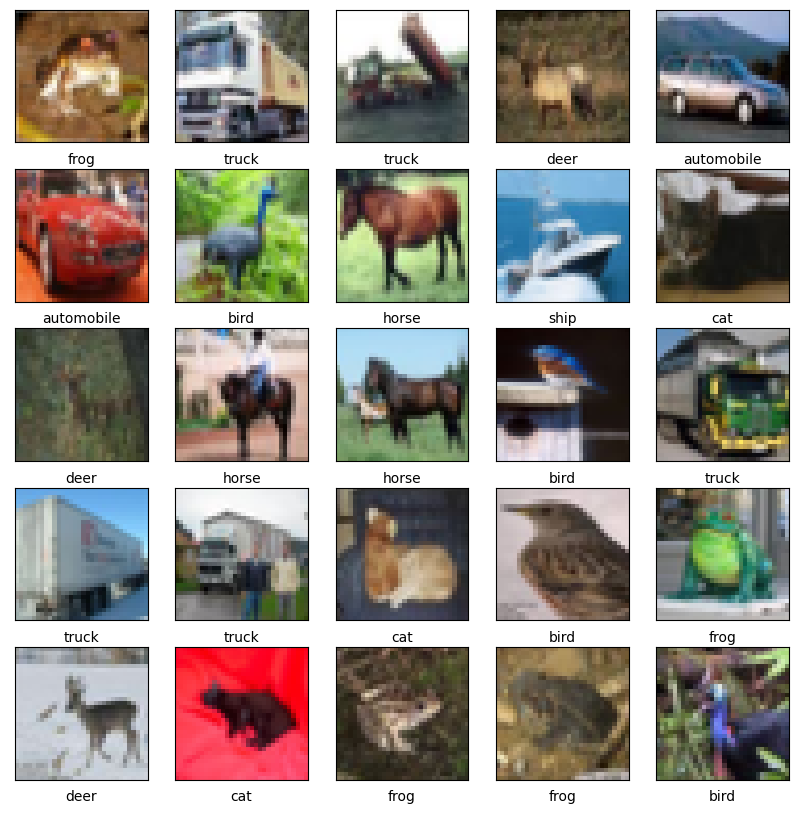

In [10]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Convolutional Neural Network

In [11]:
# Build the conv model.
print("building the convolution model...")
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding="same"),
        tf.keras.layers.ReLU(name="relu1"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
        tf.keras.layers.ReLU(name="relu2"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
        tf.keras.layers.ReLU(name="relu3"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)

# Compile the mode with the necessary loss function and optimizer.
print("compiling the convolution model...")
conv_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", 
            tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")
            ],
)
# Create a learning rate scheduler callback.
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                          factor=0.7,
                                                          min_delta=0.001,
                                                          patience=3,
                                                          mode="auto")
    
 # Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=CFG.early_stopping_patience,
        restore_best_weights=True,
        min_delta=0.001,
    )
history = conv_model.fit(
    train_ds,
    batch_size=CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=test_ds,
    callbacks=[reduceLROnPlat, early_stopping],
)


_, accuracy, top_5_accuracy = history.model.evaluate(test_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

building the convolution model...
compiling the convolution model...
Epoch 1/100
196/196 [==============================] - 3s 4ms/step - loss: 1.6367 - accuracy: 0.4105 - top-5-accuracy: 0.4692 - val_loss: 1.3576 - val_accuracy: 0.5075 - val_top-5-accuracy: 0.4114 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - 1s 3ms/step - loss: 1.2488 - accuracy: 0.5571 - top-5-accuracy: 0.4670 - val_loss: 1.1561 - val_accuracy: 0.5892 - val_top-5-accuracy: 0.4068 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - 1s 3ms/step - loss: 1.0850 - accuracy: 0.6199 - top-5-accuracy: 0.4807 - val_loss: 1.0676 - val_accuracy: 0.6236 - val_top-5-accuracy: 0.4217 - lr: 0.0010
Epoch 4/100
196/196 [==============================] - 1s 3ms/step - loss: 0.9768 - accuracy: 0.6586 - top-5-accuracy: 0.4882 - val_loss: 0.9698 - val_accuracy: 0.6605 - val_top-5-accuracy: 0.4577 - lr: 0.0010
Epoch 5/100
196/196 [==============================] - 1s 3ms/step - loss: 0.9052 - accurac

196/196 [==============================] - 1s 3ms/step - loss: 0.1062 - accuracy: 0.9741 - top-5-accuracy: 0.5021 - val_loss: 1.2808 - val_accuracy: 0.7290 - val_top-5-accuracy: 0.5020 - lr: 1.1765e-04
Epoch 40/100
196/196 [==============================] - 1s 3ms/step - loss: 0.1013 - accuracy: 0.9758 - top-5-accuracy: 0.4999 - val_loss: 1.2935 - val_accuracy: 0.7271 - val_top-5-accuracy: 0.4954 - lr: 1.1765e-04
Epoch 41/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0959 - accuracy: 0.9786 - top-5-accuracy: 0.4989 - val_loss: 1.3084 - val_accuracy: 0.7283 - val_top-5-accuracy: 0.5089 - lr: 1.1765e-04
Epoch 42/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0913 - accuracy: 0.9796 - top-5-accuracy: 0.4996 - val_loss: 1.3049 - val_accuracy: 0.7301 - val_top-5-accuracy: 0.5218 - lr: 8.2354e-05
Epoch 43/100
196/196 [==============================] - 1s 3ms/step - loss: 0.0863 - accuracy: 0.9815 - top-5-accuracy: 0.4992 - val_loss: 1.3152 - val_a

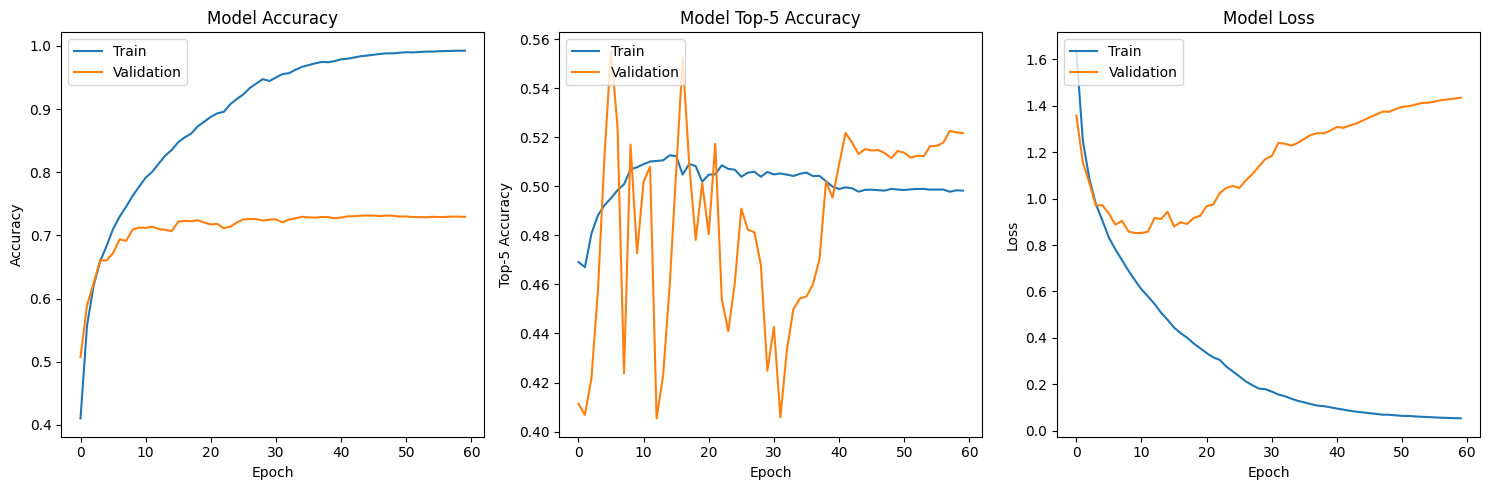

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for top-5 accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['top-5-accuracy'])
    plt.plot(history.history['val_top-5-accuracy'])
    plt.title('Model Top-5 Accuracy')
    plt.ylabel('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
plot_history(history)

1/1 [==============================] - 0s 10ms/step


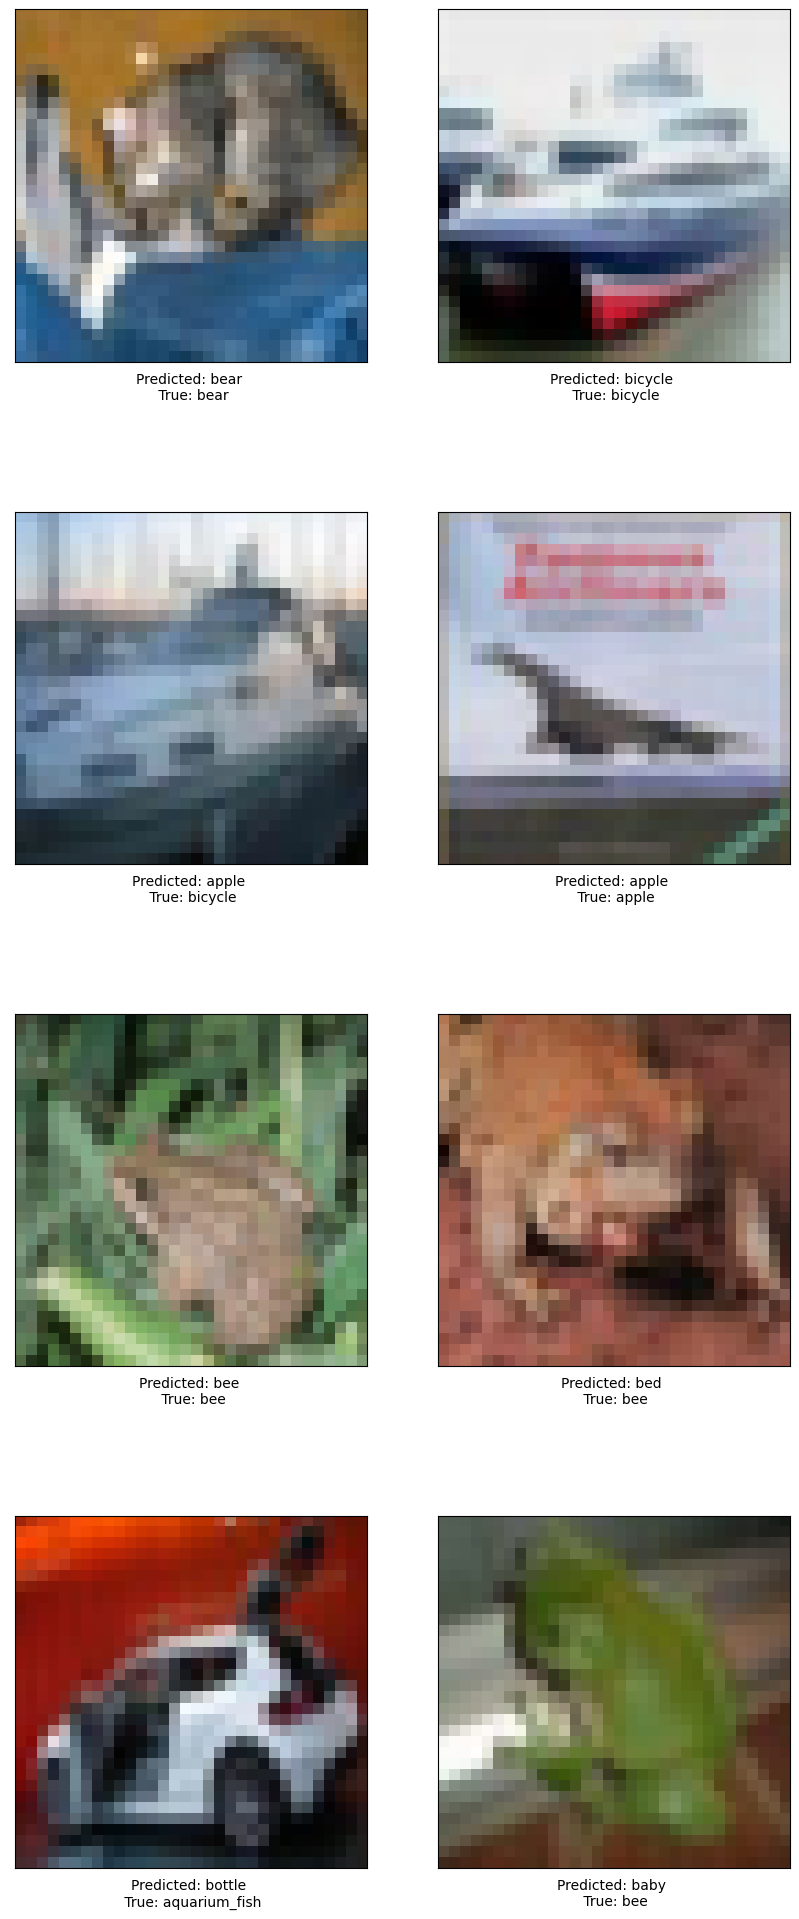

In [17]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

    pred = history.model.predict(test_images[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = int(test_labels[i])

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label]}")
plt.show()

# Involutional Neural Network

In [13]:
# Build the involution model.
print("building the involution model...")

inputs = tf.keras.Input(shape=(32, 32, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(10)(x)

inv_model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        "accuracy", 
        tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")
            ],
)

inv_hist = inv_model.fit(
        train_ds,
        batch_size=CFG.batch_size,
        epochs=CFG.epochs,
        validation_data=test_ds,
        callbacks=[reduceLROnPlat, early_stopping],
    )


_, accuracy, top_5_accuracy = inv_hist.model.evaluate(test_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

building the involution model...
compiling the involution model...
Epoch 1/100
196/196 [==============================] - 3s 7ms/step - loss: 2.1368 - accuracy: 0.2206 - top5-acc: 0.7127 - val_loss: 2.0626 - val_accuracy: 0.2835 - val_top5-acc: 0.7917 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - 1s 5ms/step - loss: 1.8779 - accuracy: 0.3266 - top5-acc: 0.8247 - val_loss: 1.8330 - val_accuracy: 0.3599 - val_top5-acc: 0.8421 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - 1s 5ms/step - loss: 1.7983 - accuracy: 0.3584 - top5-acc: 0.8482 - val_loss: 1.7761 - val_accuracy: 0.3728 - val_top5-acc: 0.8511 - lr: 0.0010
Epoch 4/100
196/196 [==============================] - 1s 6ms/step - loss: 1.7564 - accuracy: 0.3739 - top5-acc: 0.8575 - val_loss: 1.7369 - val_accuracy: 0.3882 - val_top5-acc: 0.8606 - lr: 0.0010
Epoch 5/100
196/196 [==============================] - 1s 6ms/step - loss: 1.7277 - accuracy: 0.3838 - top5-acc: 0.8656 - val_loss: 1.7112 - 

Epoch 42/100
196/196 [==============================] - 1s 6ms/step - loss: 1.4152 - accuracy: 0.4968 - top5-acc: 0.9232 - val_loss: 1.4765 - val_accuracy: 0.4805 - val_top5-acc: 0.9112 - lr: 7.0000e-04
Epoch 43/100
196/196 [==============================] - 1s 5ms/step - loss: 1.4142 - accuracy: 0.4975 - top5-acc: 0.9235 - val_loss: 1.4778 - val_accuracy: 0.4767 - val_top5-acc: 0.9138 - lr: 7.0000e-04
Epoch 44/100
196/196 [==============================] - 1s 6ms/step - loss: 1.4099 - accuracy: 0.4977 - top5-acc: 0.9236 - val_loss: 1.4686 - val_accuracy: 0.4818 - val_top5-acc: 0.9143 - lr: 7.0000e-04
Epoch 45/100
196/196 [==============================] - 1s 6ms/step - loss: 1.4014 - accuracy: 0.5018 - top5-acc: 0.9254 - val_loss: 1.4682 - val_accuracy: 0.4835 - val_top5-acc: 0.9150 - lr: 4.9000e-04
Epoch 46/100
196/196 [==============================] - 1s 5ms/step - loss: 1.3991 - accuracy: 0.5024 - top5-acc: 0.9257 - val_loss: 1.4705 - val_accuracy: 0.4817 - val_top5-acc: 0.9138 - 

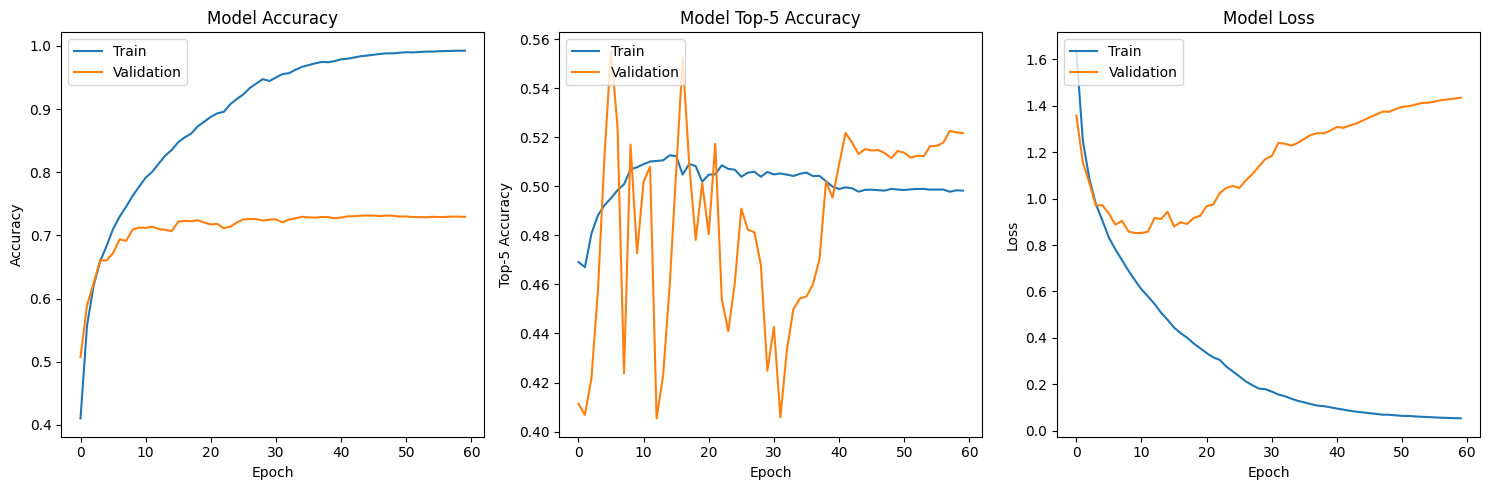

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for top-5 accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['top-5-accuracy'])
    plt.plot(history.history['val_top-5-accuracy'])
    plt.title('Model Top-5 Accuracy')
    plt.ylabel('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
plot_history(history)

1/1 [==============================] - 0s 9ms/step


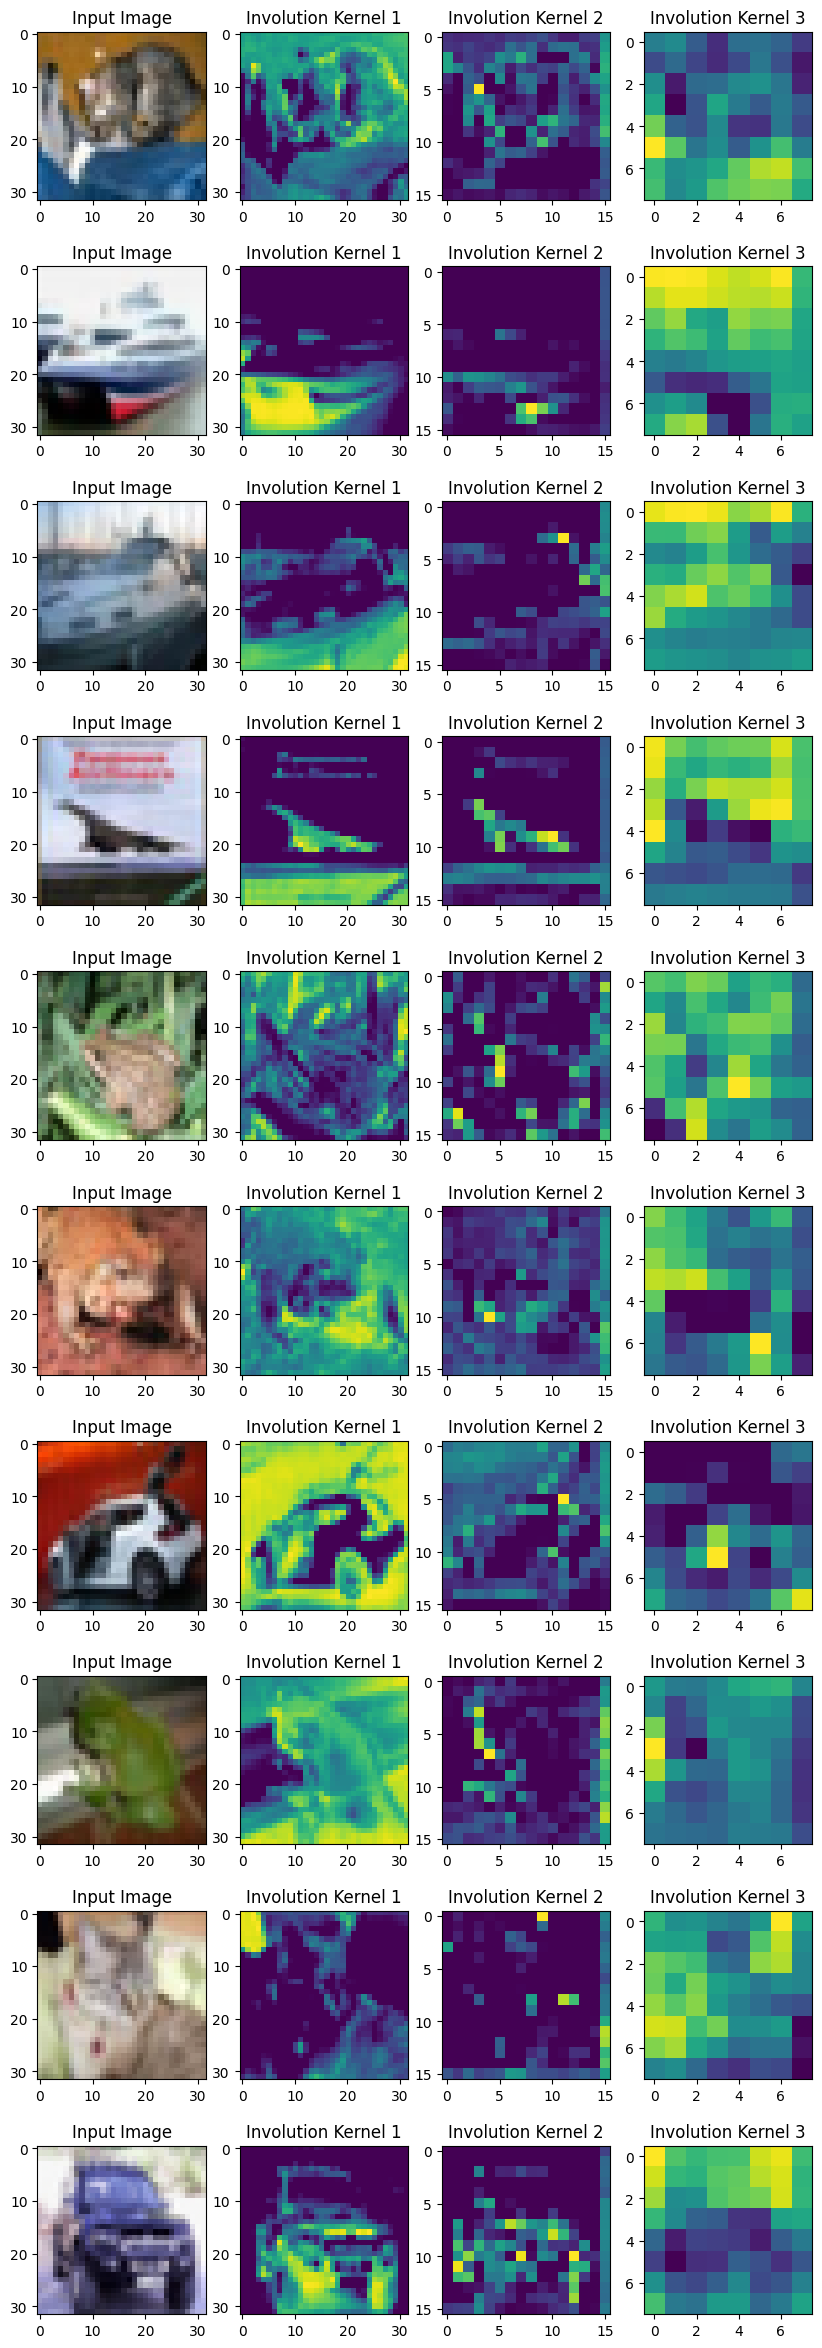

In [15]:
layer_names = ["inv_1", "inv_2", "inv_3"]
outputs = [inv_model.get_layer(name).output for name in layer_names]
vis_model = tf.keras.Model(inv_model.input, outputs)

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

for ax, test_image in zip(axes, test_images[:10]):
    (inv1_out, inv2_out, inv3_out) = vis_model.predict(test_image[None, ...])

    _, inv1_kernel = inv1_out
    _, inv2_kernel = inv2_out
    _, inv3_kernel = inv3_out

    inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
    inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
    inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])

    ax[0].imshow(tf.keras.utils.array_to_img(test_image))
    ax[0].set_title("Input Image")

    ax[1].imshow(tf.keras.utils.array_to_img(inv1_kernel[0, ..., None]))
    ax[1].set_title("Involution Kernel 1")

    ax[2].imshow(tf.keras.utils.array_to_img(inv2_kernel[0, ..., None]))
    ax[2].set_title("Involution Kernel 2")

    ax[3].imshow(tf.keras.utils.array_to_img(inv3_kernel[0, ..., None]))
    ax[3].set_title("Involution Kernel 3")

1/1 [==============================] - 0s 9ms/step


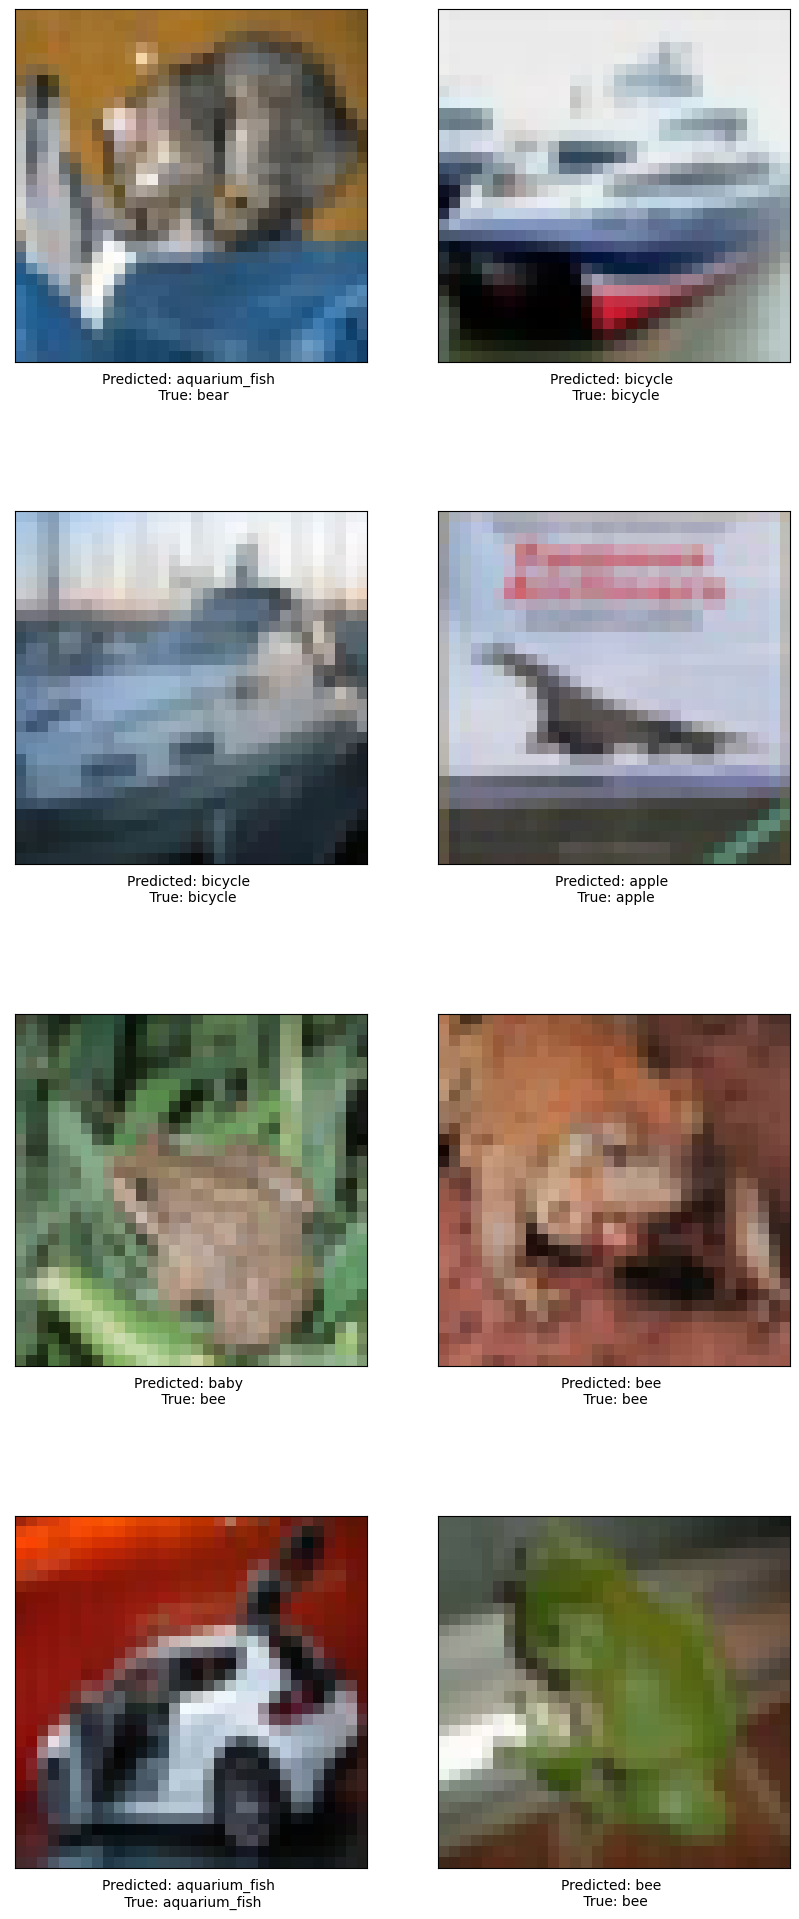

In [16]:
# Visualization X_test
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
    
plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)

    pred = inv_hist.model.predict(test_images[i].reshape(1, 32, 32, 3))
    pred_label = np.argmax(pred)
    true_label = int(test_labels[i])

    color = 'blue' if pred_label == true_label else 'red'

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label]}")
plt.show()